In [4]:
! pip install utm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
import utm

In [2]:
data = pd.read_csv('preprocessed_data.csv')
data.head()

,Unnamed: 0,cat2_slug,cat3_slug,city_slug,neighborhood_slug,created_at_month,description,title,building_size,floor,...,has_warm_water_provider,has_heating_system,has_cooling_system,has_restroom,building_direction,floor_material,location_latitude,location_longitude,location_radius,merged_price
0,12,residential-sell,apartment-sell,mashhad,farhang,2024-06-01 00:00:00,با سلام\n\n✨✨ شما لایق بهترین ها هستید ✨✨\n\n✅...,تاپ لوکیشن جلال سروش ۱۶۹متر کلید موجود قبل فرهنگ,169.0,2,...,package,duct_split,duct_split,squat_seat,south,ceramic,36.321831,59.524502,500.0,12990.0
1,43,residential-sell,apartment-sell,mashhad,ghasemabad,2024-06-01 00:00:00,▪️▫️⚜بنام خداوند روزی دهنده مهربان⚜▫️▪️ \n\n\n...,آپارتمان ۱۱۰متری*خوش چیدمان*۸واحدی/ فلاحی۳۸,110.0,2,...,package,shoofaj,water_cooler,squat_seat,south,ceramic,36.365303,59.499275,500.0,3500.0
2,48,residential-rent,apartment-rent,tehran,west-tehranpars,2024-07-01 00:00:00,✅.....املاک بزرگ تهرانپارس:سام.....✅\n\n\n86 م...,86متر*2خواب*کلید نخورده*فول*بهترین لوکیشن,86.0,2,...,package,shoofaj,water_cooler,squat_seat,south,stone,35.739414,51.525150,500.0,12000.0
3,66,residential-sell,apartment-sell,karaj,andishehnewcity,2024-05-01 00:00:00,♻️این واحد یه پیشنهاد عالی برای شما اگه دوست د...,آپارتمان۱۰۷متری،روبه نما،فول امکانات،شهرک صدف,107.0,2,...,package,shoofaj,air_conditioner,squat,north,ceramic,35.688915,51.039005,500.0,5400.0
4,99,residential-sell,apartment-sell,isfahan,dashtestan,2024-12-01 00:00:00,❇️ دفتر مهندسی و املاک حمید شعبه مرکزی ❇️\n➖➖➖...,واحد ۱۴۵متری ۳ خواب غرق نور شیک دسترسی پروین,145.0,4,...,package,shoofaj,water_cooler,squat_seat,south,ceramic,32.684116,51.716213,500.0,5680.0


In [3]:
data.set_index('Unnamed: 0', inplace=True)

In [4]:
data.drop(['title', 'description'], axis=1, inplace=True)

In [5]:
data['utm_easting'], data['utm_northing'], data['zone_number'], data['zone_letter'] = zip(*data.apply(lambda row: utm.from_latlon(row['location_latitude'], row['location_longitude']), axis=1))

In [6]:
data.drop(['zone_number', 'zone_letter', 'location_latitude', 'location_longitude'], axis=1, inplace=True)

In [7]:
def persian_to_english(s):
    if pd.isnull(s):
        return s
    mapping = str.maketrans("۰۱۲۳۴۵۶۷۸۹", "0123456789")
    return str(s).translate(mapping)

# Apply to 'construction_year'
data["construction_year"] = data["construction_year"].replace("قبل از ۱۳۷۰", "۱۳۶۹")
data["construction_year"] = data["construction_year"].apply(persian_to_english)

# Convert to numeric
data["construction_year"] = pd.to_numeric(data["construction_year"], errors="coerce")

data["construction_year"].unique()

array([1403, 1394, 1400, 1401, 1397, 1390, 1391, 1383, 1386, 1392, 1395,
       1399, 1398, 1384, 1396, 1378, 1385, 1393, 1402, 1380, 1387, 1388,
       1375, 1382, 1389, 1373, 1371, 1379, 1377, 1381, 1372, 1374, 1376,
       1369])

In [8]:
transformDic ={"بدون اتاق":0,"یک":1,"دو":2,"سه":3,"چهار":4,"پنج یا بیشتر":5}
data["rooms_count"] = data["rooms_count"].replace(transformDic)

/tmp/ipykernel_7314/2362534829.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["rooms_count"] = data["rooms_count"].replace(transformDic)


In [9]:
std_map = {
    'true': True,
    'false': False,
    'True': True,
    'False': False,
    'unselect': np.nan
}
has_columns = data.filter(like="has_").columns
data[has_columns] = data[has_columns].replace(std_map)

In [10]:
data.iloc[0]

cat2_slug                     residential-sell
cat3_slug                       apartment-sell
city_slug                              mashhad
neighborhood_slug                      farhang
created_at_month           2024-06-01 00:00:00
building_size                            169.0
floor                                        2
rooms_count                                  3
total_floors_count                           6
unit_per_floor                               1
has_balcony                               True
has_elevator                              True
has_warehouse                             True
has_parking                               True
construction_year                         1403
is_rebuilt                               False
has_warm_water_provider                package
has_heating_system                  duct_split
has_cooling_system                  duct_split
has_restroom                        squat_seat
building_direction                       south
floor_materia

In [11]:
data.dropna(inplace=True)

In [12]:
data.drop('created_at_month', axis=1, inplace=True)

In [13]:
data['has_balcony'] = data['has_balcony'].astype(int)
data['has_elevator'] = data['has_elevator'].astype(int)
data['has_warehouse'] = data['has_warehouse'].astype(int)
data['is_rebuilt'] = data['is_rebuilt'].astype(int)
data['has_parking'] = data['has_parking'].astype(int)

In [14]:
data = pd.get_dummies(data, columns=['cat2_slug', 'cat3_slug', 'city_slug', 'neighborhood_slug',
                                     'has_heating_system', 'has_cooling_system', 'has_restroom', 'building_direction',
                                     'floor_material', 'has_warm_water_provider'], drop_first=True, dtype=int)

In [15]:
def convert_floor(x):
    if x == '30+':
        return 30
    return float(x)
data['floor'] = data['floor'].apply(lambda x: convert_floor(x))
data['total_floors_count'] = data['total_floors_count'].apply(lambda x: convert_floor(x))

In [16]:
def convert_unit(x):
    if x == 'more_than_8':
        return 9
    elif x == 'unselect':
        return float('nan')
    return float(x)
data['unit_per_floor'] = data.unit_per_floor.apply(lambda x: convert_unit(x))

### Part One

<div dir="rtl">
حال الگوریتم خوشه‌بندی K-means را تنها بر حسب با ۱۰ خوشه برای این مجموعه‌داده اجرا کنید. سپس ابتدا مختصات جغرافیایی را به فرمت UTM درآورید و  برای دو ویژگی قیمت و مختصات UTM یک اسکترپلات رسم کنید. بر روی اسکتر پلات رسم‌شده مشخص کنید کدام نقاط مربوط به کدام خوشه هستند و مرکز هر خوشه را نیز رسم کنید. به انتخاب رنگ، مارکر، نام‌گذاری محور‌ها و به‌طور کلی قابل درک بودن تصویر دقت داشته باشید.
</div>

In [20]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(data)
centers = kmeans.cluster_centers_

In [25]:
for i, col in enumerate(data.columns):
    if col == 'utm_easting' or col == 'utm_northing' or col == 'merged_price':
        print(f'{col}: {i}')
    

merged_price: 12
utm_easting: 13
utm_northing: 14


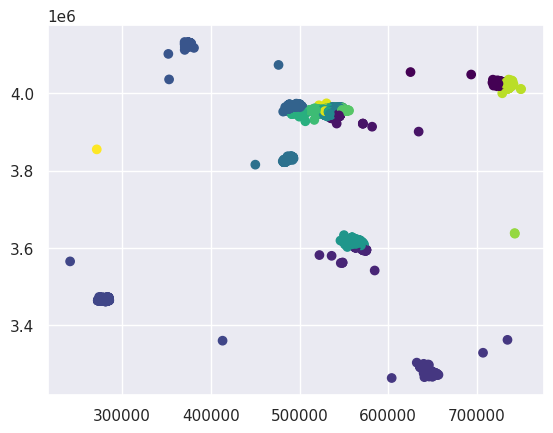

In [71]:
plt.scatter(data.utm_easting, data.utm_northing, c=kmeans.labels_, cmap='viridis')
plt.show()

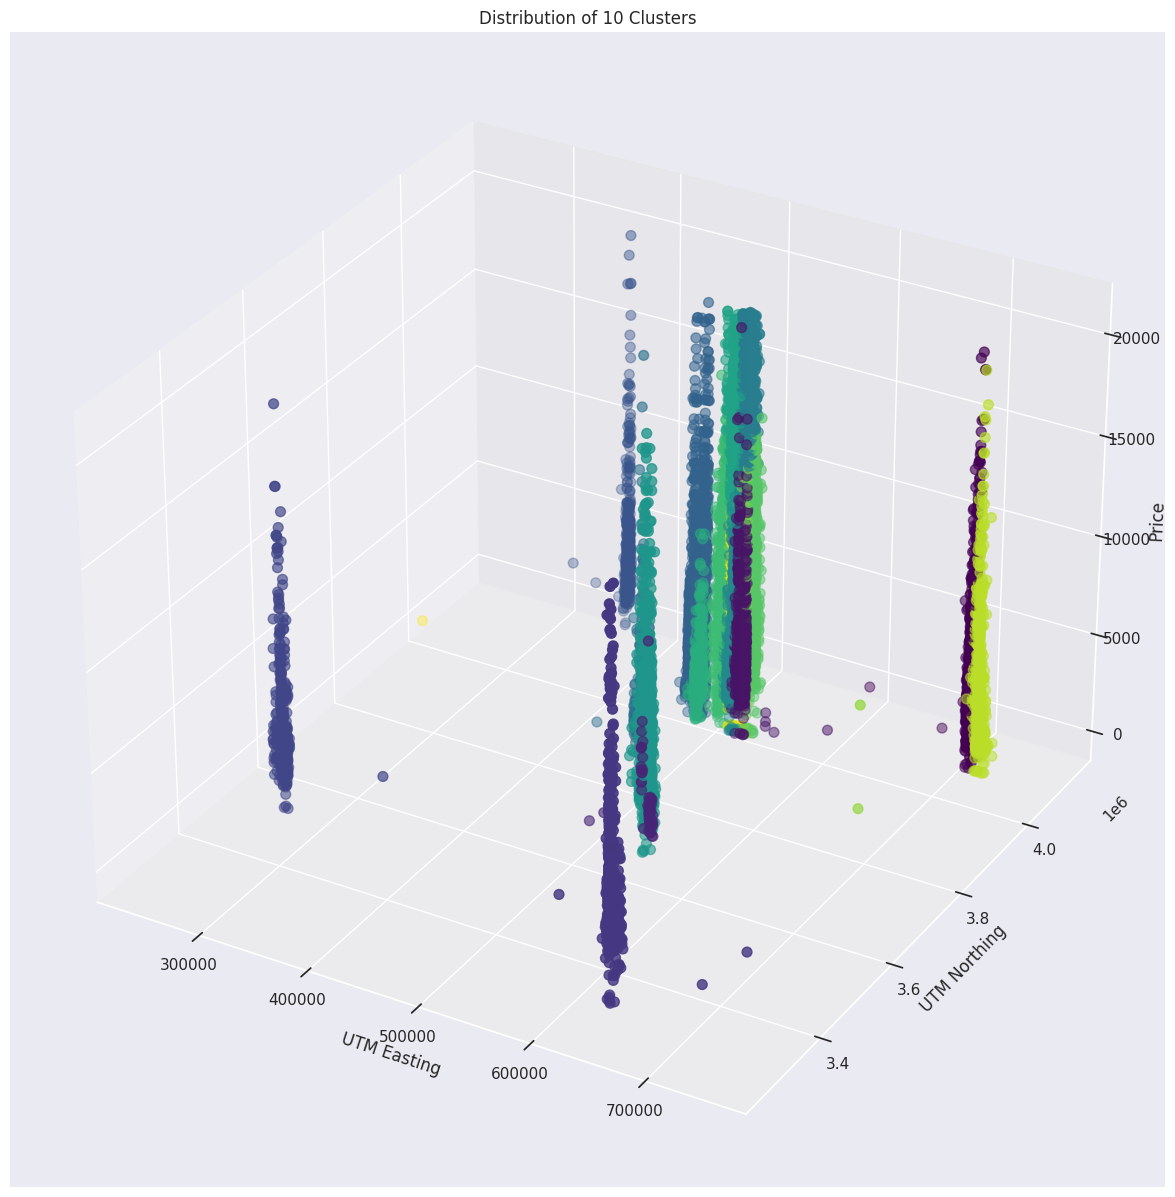

In [70]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.utm_easting, data.utm_northing, data.merged_price,
           c=kmeans.labels_, s=50, marker='o', cmap='viridis')
ax.set_xlabel('UTM Easting')
ax.set_ylabel('UTM Northing')
ax.set_zlabel('Price')
ax.set_title('Distribution of 10 Clusters')
#plt.savefig('kmeans_3d_clusters.png', dpi=300)
plt.show()

### Part Two

<div dir='rtl'>
پس از آن الگوریتم K-means را برای k هایی از ۱ تا ۲۰ اجرا کرده و با محاسبه‌ی مجموع مجذورات درون خوشه‌ای  (Within-Cluster Sum of Square)، مقدار مناسبی برای هایپرپارامتر k انتخاب کنید. توجه کنید که بخش زیادی از نمره‌ی این بخش مربوط به نحوه‌ی انتخاب مقدار k است و چنان‌چه روش‌های تدریس‌شده و معمول پاسخگوی حل مسئله نبود،انتظار می‌رود با جستجو و مطالعه‌ی بیشتر، روشی مناسب برای رفع چالش‌های احتمالی پیشنهاد دهید. 
</div>

In [36]:
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(data)
    print(f'clustering done with k: {k}')
    wcss.append(kmeans.inertia_)

clustering done with k: 1
clustering done with k: 2
clustering done with k: 3
clustering done with k: 4
clustering done with k: 5
clustering done with k: 6
clustering done with k: 7
clustering done with k: 8
clustering done with k: 9
clustering done with k: 10
clustering done with k: 11
clustering done with k: 12
clustering done with k: 13
clustering done with k: 14
clustering done with k: 15
clustering done with k: 16
clustering done with k: 17
clustering done with k: 18
clustering done with k: 19
clustering done with k: 20


In [39]:
sns.set_theme()

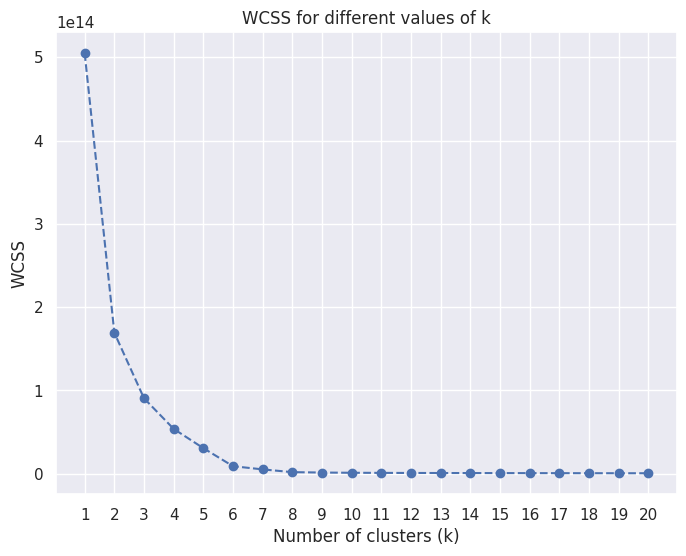

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--', color='b')
plt.title('WCSS for different values of k')
plt.xlabel('Number of clusters (k)')
plt.xticks(range(1, 21))
plt.ylabel('WCSS')
plt.savefig('')
plt.show()

### Part Three

<div dir='rtl'>
در آخرین گام از این سوال از شما می‌خواهیم که ابتدا دو ویژگی مختصات UTM و قیمت قابل تبدیل را در نظر بگیرید و سپس با استفاده از روش DBScan داده‌ها را فقط با در نظر گرفتن این دو ویژگی خوشه‌بندی کنید و هایپرپارامتر‌ها را به‌نحوی تغییر دهید که ۳ کلاستر بامعنا در خروجی تولید شود. اسکتر پلات داده‌ها و نحوه‌ی خوشه‌بندی آن‌ها را مطابق بخش ۱ رسم کنید. نحوه‌ی اثرگذاری هر یک از هایپرپارامتر‌ها بر خروجی را توضیح دهید. 
</div>

In [33]:
scaled_data = StandardScaler().fit_transform(data[['utm_easting', 'utm_northing', 'merged_price']])
eps_values = np.linspace(0.5, 3.0, 26)
min_samples_values = list(range(2, 8)) 
results = []
for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(scaled_data)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        results.append({
            'eps': eps,
            'min_samples': ms,
            'n_clusters': n_clusters,
            'n_noise': np.sum(labels == -1)
        })
        print(f'performed clustering for eps: {eps} and min_sample: {ms}', end='\r')
df_results = pd.DataFrame(results)
three_cluster_settings = df_results[df_results['n_clusters'] == 3].copy()
three_cluster_settings = three_cluster_settings.sort_values(by=['n_noise', 'eps'], ascending=[True, True]).reset_index(drop=True)

In [34]:
three_cluster_settings

,eps,min_samples,n_clusters,n_noise
0,2.0,2,3,0
1,1.8,3,3,3
2,1.8,4,3,3
3,1.8,5,3,3
4,1.8,6,3,3
5,1.8,7,3,3
6,1.9,3,3,3
7,1.9,4,3,3
8,1.9,5,3,3
9,1.9,6,3,3


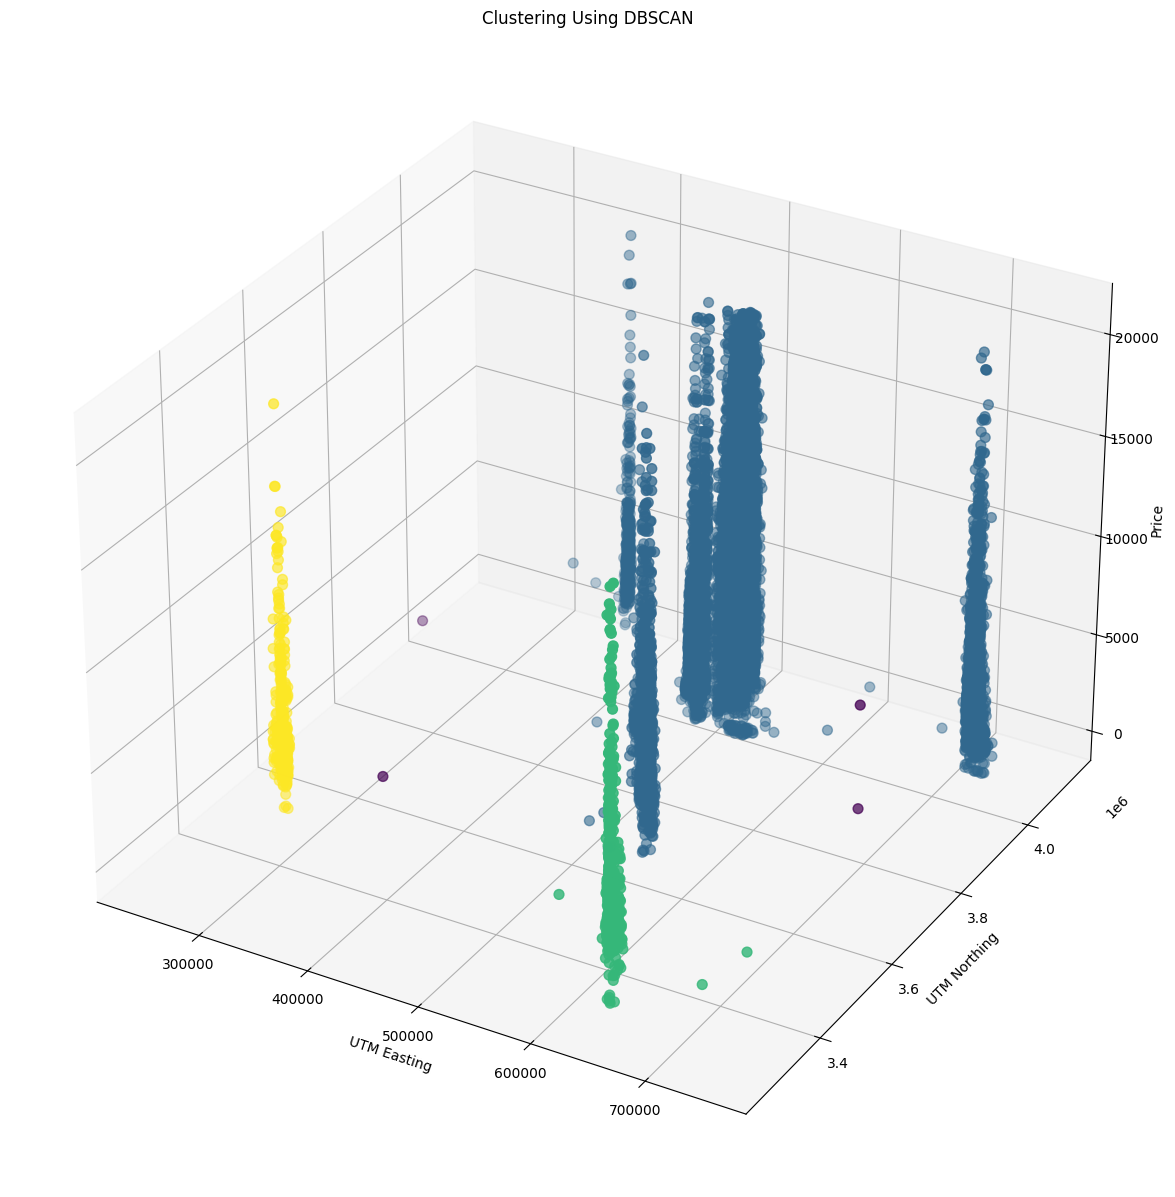

In [38]:
dbscan = DBSCAN(eps=1.7, min_samples=7)
dbscan_labels = dbscan.fit_predict(scaled_data)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.utm_easting, data.utm_northing, data.merged_price,
           c=dbscan_labels, s=50, marker='o', cmap='viridis')
ax.set_xlabel('UTM Easting')
ax.set_ylabel('UTM Northing')
ax.set_zlabel('Price')
ax.set_title('Clustering Using DBSCAN')
plt.show()

In [30]:
np.unique(dbscan_labels)

array([-1,  0,  1,  2,  3])